In [1]:
from copy import deepcopy
from pylab import rcParams
from datetime import datetime, timedelta
from rpy2.robjects import r
from rpy2.robjects import pandas2ri as pd2
from forecast import forecast, stl, stldf, bind

pd2.activate()

import pandas as pd

bind(pd.DataFrame, stldf)
bind(pd.Series, stl, forecast)

%matplotlib inline
rcParams['figure.figsize'] = 10, 5

get_date = lambda x: datetime.strptime(x, '%Y-%m-%d')
get_str = lambda x: datetime.strftime(x, '%Y-%m-%d')

In [2]:
data = pd.read_csv('df0.csv')

In [3]:
data.head()

,date,se,browser,hits
0,2014-01-01,search,chrome,44778823.0
1,2014-01-01,yandex,chrome,16237589.0
2,2014-01-02,search,chrome,52448725.0
3,2014-01-02,yandex,chrome,18979110.0
4,2014-01-03,search,chrome,54640145.0


In [4]:
data['date'].min(), data['date'].max()

('2014-01-01', '2017-09-28')

In [5]:
type(data['date'][0])

str

In [6]:
data['se'].unique()

array(['search', 'yandex'], dtype=object)

In [7]:
data['browser'].unique()

array(['chrome', 'firefox', 'msie', 'opera', 'yabrowser'], dtype=object)

Проверка на отстствующие даты:

In [8]:
to_append = []

for i in range(len(data) - 2):
    if i % 2 == 0:
        assert data.iloc[i]['date'] == data.iloc[i + 1]['date'], i
    diff = (get_date(data.iloc[i + 2]['date']) - get_date(data.iloc[i]['date'])).days
    if diff != 1:
        value = data.iloc[i]
        if value['date'] != data['date'].max():
            for t in range(1, diff):
                to_append.append({
                    'date':get_str(get_date(value['date']) + timedelta(days=t)),
                    'se':value['se'],
                    'browser':value['browser'],
                    'hits': 0
                })

In [9]:
data = data.append(pd.DataFrame(to_append), ignore_index=True)

In [10]:
data = data.sort_values(['browser', 'date'])
data.index = range(len(data))

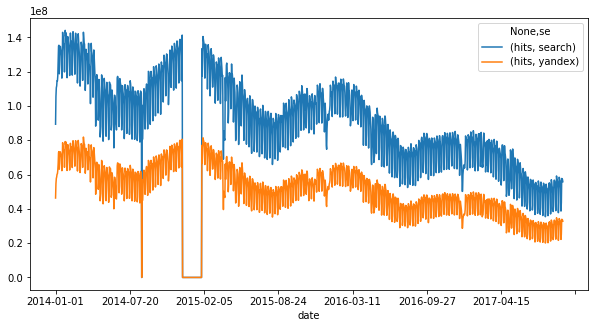

In [11]:
data.pivot_table(index='date', columns='se', aggfunc=sum).plot()

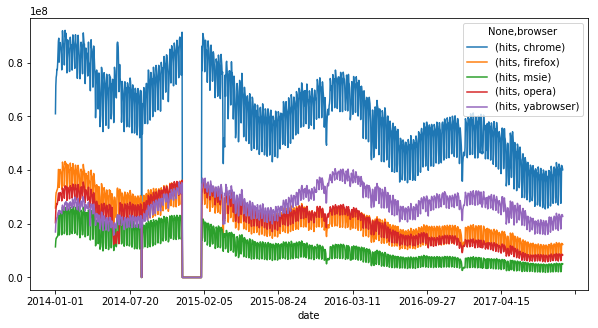

In [12]:
data.pivot_table(index='date', columns='browser', aggfunc=sum).plot()

Видно, что есть отсутствующие точка `2014-08-21` и промежуток `2014-12-09 -- 2015-01-29` включительно.

Чтобы восстановить недостающие значения, давайте посмотрим на данные в тот же период в следующем году и отмасштабируем с учетом текущих данных.

Сделаем так для каждой серии, то есть для каждой пары (`se`, `browser`).

Исправленный ряд будет храниться в колонке `hits_fixed`.

In [13]:
hits_fixed = deepcopy(data['hits'])

In [14]:
for se in data['se'].unique():
    for browser in data['browser'].unique():
        pair = (data['se'] == se) & (data['browser'] == browser)
        ind = data[pair & (data['date'] == '2014-08-21')].index[0]
        offset, value = data[pair & (data['date'] >= '2015-08-20') & (data['date'] <= '2015-08-21')]['hits']
        current = data[pair & (data['date'] == '2014-08-20')]['hits'].values[0]
        hits_fixed[ind] = current + (value - offset)
        
        ind = data[pair & (data['date'] >= '2014-12-09') & (data['date'] <= '2015-01-29')].index
        values = data[pair & (data['date'] >= '2015-12-09') & (data['date'] <= '2016-01-29')]['hits']
        offset = data[pair & (data['date'] == '2015-12-08')]['hits'].values[0]
        current = data[pair & (data['date'] == '2014-12-08')]['hits'].values[0]
        
        hits_fixed[ind] = values + current - offset

In [15]:
data['hits_fixed'] = hits_fixed

Данные до и после фиксов:

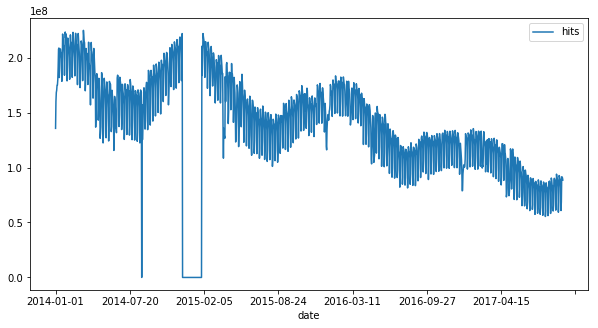

In [16]:
data.drop(['hits_fixed'], axis=1).pivot_table(index='date', aggfunc=sum).plot()

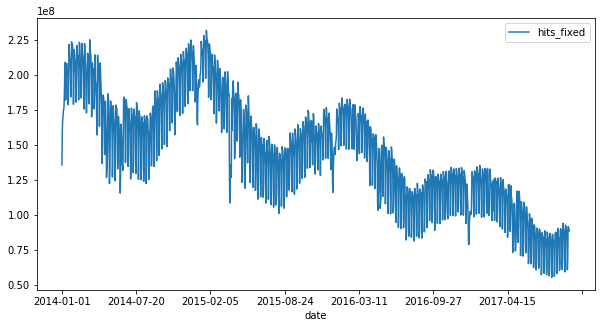

In [17]:
data.drop(['hits'], axis=1).pivot_table(index='date', aggfunc=sum).plot()

Получим теперь ряды `hits_week_trend`, `hits_week_seasonal`, `hits_year_trend` и `hits_year_seasonal`.

In [18]:
hits_week_trend = deepcopy(data['hits_fixed'])
hits_week_seasonal = deepcopy(data['hits_fixed'])
hits_year_trend = deepcopy(data['hits_fixed'])
hits_year_seasonal = deepcopy(data['hits_fixed'])

In [19]:
for se in data['se'].unique():
    for browser in data['browser'].unique():
        pair = (data['se'] == se) & (data['browser'] == browser)
        ind = data[pair].index
        week_decomposition = data[pair]['hits_fixed'].stl(frequency=7)
        hits_week_trend[ind] = week_decomposition['hits_fixed_trend']
        hits_week_seasonal[ind] = week_decomposition['hits_fixed_seasonal']
        year_decomposition = week_decomposition['hits_fixed_trend'].stl(frequency=365)
        hits_year_trend[ind] = year_decomposition['hits_fixed_trend_trend']
        hits_year_seasonal[ind] = year_decomposition['hits_fixed_trend_seasonal']

In [20]:
data['hits_week_trend'] = hits_week_trend
data['hits_week_seasonal'] = hits_week_seasonal
data['hits_year_trend'] = hits_year_trend
data['hits_year_seasonal'] = hits_year_seasonal

In [21]:
data.head()

,browser,date,hits,se,hits_fixed,hits_week_trend,hits_week_seasonal,hits_year_trend,hits_year_seasonal
0,chrome,2014-01-01,44778823.0,search,44778823.0,4.961249e+07,-6.275043e+05,5.522497e+07,-2.275436e+06
1,chrome,2014-01-01,16237589.0,yandex,16237589.0,1.789726e+07,-1.012758e+05,2.172304e+07,-1.387952e+06
2,chrome,2014-01-02,52448725.0,search,52448725.0,5.117192e+07,1.219221e+06,5.522219e+07,-1.713970e+06
3,chrome,2014-01-02,18979110.0,yandex,18979110.0,1.857277e+07,5.146400e+05,2.171865e+07,-1.154810e+06
4,chrome,2014-01-03,54640145.0,search,54640145.0,5.273136e+07,4.886709e+05,5.521940e+07,-9.077853e+05


In [22]:
import matplotlib.pyplot as plt

%matplotlib inline

rcParams['figure.figsize'] = 10, 7

Как в общих чертах менялась доля Яндекса в исследуемых браузерах?

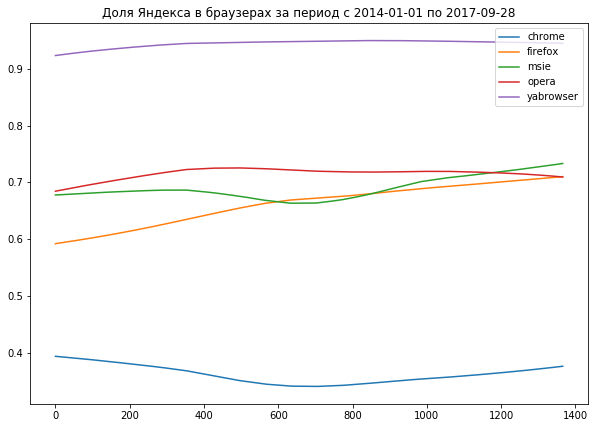

In [23]:
for browser in data['browser'].unique():
    yandex = data[(data['se'] == 'yandex') & (data['browser'] == browser)]['hits_year_trend']
    search = data[(data['se'] == 'search') & (data['browser'] == browser)]['hits_year_trend']
    plt.plot(range(len(search)), yandex.values / search.values, label=browser)
    plt.title('Доля Яндекса в браузерaх за период с {} по {}'.format(data['date'].min(), data['date'].max()))
    plt.legend()
plt.show()

Как менялась доля браузеров, если учитывать только поисковую траффикогенерацию?

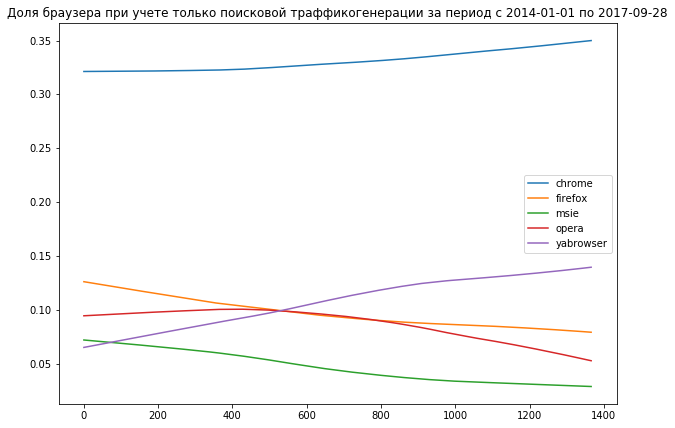

In [24]:
all_browsers = data[(data['se'] == 'search') & (data['browser'] == 'chrome')]['hits_year_trend'].values
for browser in data['browser'].unique():
    if browser == 'chrome':
        pass
    all_browsers += data[(data['se'] == 'search') & (data['browser'] == browser)]['hits_year_trend'].values

for browser in data['browser'].unique():
    current = data[(data['se'] == 'search') & (data['browser'] == browser)]['hits_year_trend'].values
    plt.plot(range(len(current)), current / all_browsers, label=browser)
    plt.title('Доля браузера при учете только поисковой траффикогенерации за период с {} по {}'.format(data['date'].min(), data['date'].max()))
    plt.legend()
plt.show()

Как менялась доля поисков внутри браузеров?

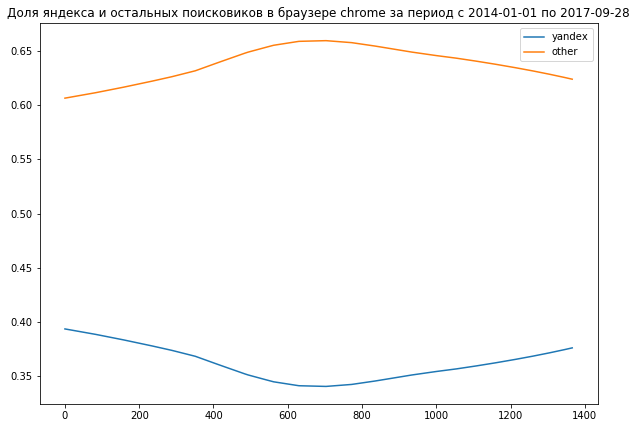

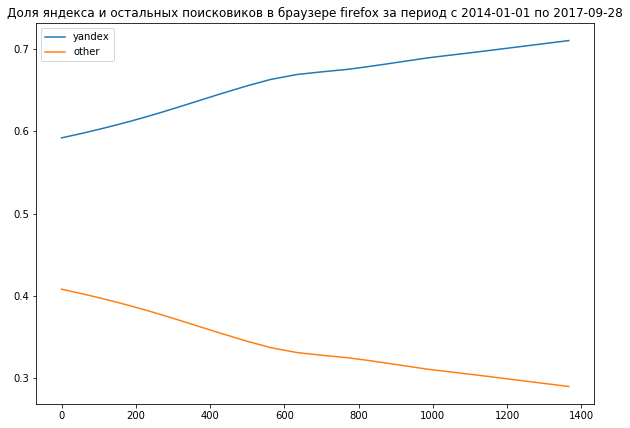

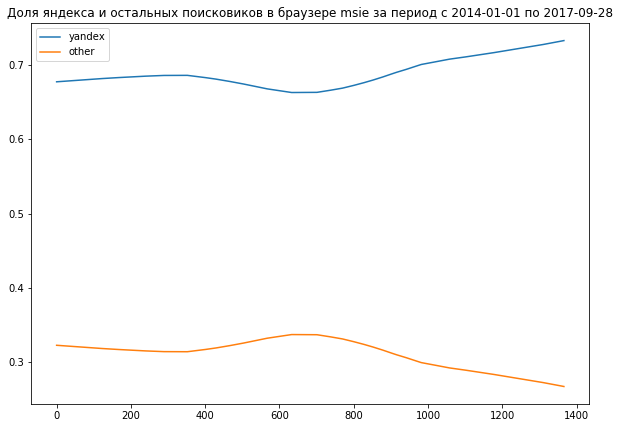

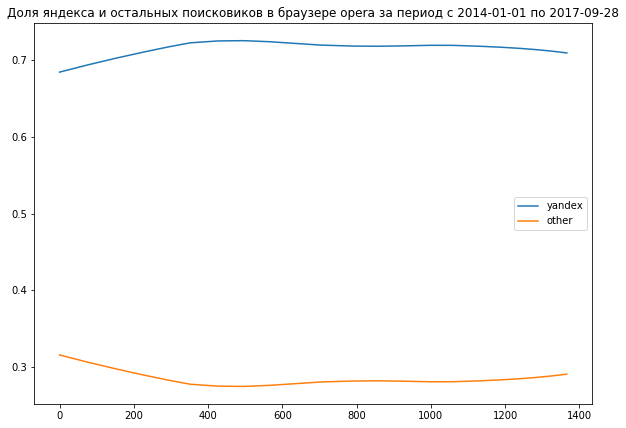

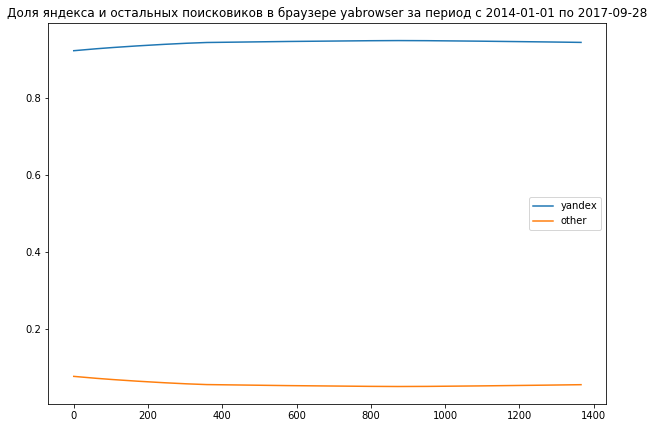

In [26]:
for browser in data['browser'].unique():
    yandex = data[(data['se'] == 'yandex') & (data['browser'] == browser)]['hits_year_trend'].values
    search = data[(data['se'] == 'search') & (data['browser'] == browser)]['hits_year_trend'].values
    plt.plot(range(len(search)), yandex / search, label='yandex')
    plt.plot(range(len(search)), (search - yandex) / search, label='other')
    plt.title('Доля яндекса и остальных поисковиков в браузере {} за период с {} по {}'.format(browser,
                                                                                               data['date'].min(),
                                                                                               data['date'].max()))
    plt.legend()
    plt.show()